In [28]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score,
    f1_score,
    precision_score,
    average_precision_score,
    roc_curve)

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

# Settings

In [30]:
random_seed = 1
batch_size = 128
num_epochs = 100
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
np.random.seed(random_seed)

# Datasets

In [31]:
training = pd.read_csv('data/segments_training.csv', index_col=0).drop(columns='geometry')
testing = pd.read_csv('data/segments_testing.csv', index_col=0).drop(columns='geometry')

X_train = training.drop(columns='landslide').to_numpy()
Y_train = training['landslide'].to_numpy()[:, None]
X_test = testing.drop(columns='landslide').to_numpy()
Y_test = testing['landslide'].to_numpy()[:, None]

# Scale data to have a mean of 0 and a var of 0
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

X_train_t = torch.tensor(X_train.astype(np.float32))
Y_train_t = torch.tensor(Y_train.astype(np.float32))
landslide_train = TensorDataset(X_train_t, Y_train_t)

X_test_t = torch.tensor(X_test.astype(np.float32))
Y_test_t = torch.tensor(Y_test.astype(np.float32))
landslide_test = TensorDataset(X_test_t, Y_test_t)

train_dataloader = DataLoader(dataset=landslide_train,
                              batch_size=batch_size,
                              shuffle=True)

test_dataloader = DataLoader(dataset=landslide_test,
                              batch_size=batch_size,
                              shuffle=False)

In [32]:
# Check loaders
for samples, labels in train_dataloader:
    print(samples.shape, labels.shape)
    break

torch.Size([128, 409]) torch.Size([128, 1])


# Defining the model

In [33]:
class LandslideModel(nn.Module):
    def __init__(self, input_size):
        super(LandslideModel, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(input_size, 10),
            nn.ReLU(),
            nn.Dropout(0.2))
        self.layer2 = nn.Sequential(
            nn.Linear(10, 10),
            nn.ReLU(),
            nn.Dropout(0.2))
        self._forward = nn.Sequential(
            self.layer1,
            self.layer2,
            nn.Linear(10, 1),
            nn.Sigmoid())

    def forward(self, x):
        return self._forward(x)

In [34]:
landslide_model = LandslideModel(X_test.shape[1])
# Move model to GPU
landslide_model.to(device)

LandslideModel(
  (layer1): Sequential(
    (0): Linear(in_features=409, out_features=10, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
  )
  (layer2): Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
  )
  (_forward): Sequential(
    (0): Sequential(
      (0): Linear(in_features=409, out_features=10, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2, inplace=False)
    )
    (1): Sequential(
      (0): Linear(in_features=10, out_features=10, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2, inplace=False)
    )
    (2): Linear(in_features=10, out_features=1, bias=True)
    (3): Sigmoid()
  )
)

# Training the model

In [35]:
learning_rate = 0.01
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(landslide_model.parameters(), lr=learning_rate)

In [36]:
loss_values = []

for epoch in range(num_epochs):
    for X, y in tqdm(train_dataloader, desc='Training loop'):
        # # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        X, y = X.to(device), y.to(device)
        pred = landslide_model(X)
        loss = loss_fn(pred, y)
        loss_values.append(loss.item())
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}/{num_epochs} - Train loss: {loss_values[-1]}')
print("Training Complete")

Training loop:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 1/100 - Train loss: 0.10532443970441818


Training loop:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 2/100 - Train loss: 0.08474402129650116


Training loop:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 3/100 - Train loss: 0.1647118777036667


Training loop:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 4/100 - Train loss: 0.06082871928811073


Training loop:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 5/100 - Train loss: 0.07076779007911682


Training loop:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 6/100 - Train loss: 0.08537163585424423


Training loop:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 7/100 - Train loss: 0.1040608286857605


Training loop:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 8/100 - Train loss: 0.1019883006811142


Training loop:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 9/100 - Train loss: 0.08327069878578186


Training loop:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 10/100 - Train loss: 0.09198009222745895


Training loop:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 11/100 - Train loss: 0.058211471885442734


Training loop:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 12/100 - Train loss: 0.12338656187057495


Training loop:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 13/100 - Train loss: 0.09645548462867737


Training loop:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 14/100 - Train loss: 0.07639554888010025


Training loop:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 15/100 - Train loss: 0.07178130000829697


Training loop:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 16/100 - Train loss: 0.05790875852108002


Training loop:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 17/100 - Train loss: 0.03972070664167404


Training loop:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 18/100 - Train loss: 0.08373821526765823


Training loop:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 19/100 - Train loss: 0.10358120501041412


Training loop:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 20/100 - Train loss: 0.14611899852752686


Training loop:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 21/100 - Train loss: 0.043459195643663406


Training loop:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 22/100 - Train loss: 0.09528478235006332


Training loop:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 23/100 - Train loss: 0.0687682032585144


Training loop:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 24/100 - Train loss: 0.0755714625120163


Training loop:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 25/100 - Train loss: 0.08214029669761658


Training loop:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 26/100 - Train loss: 0.0689879059791565


Training loop:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 27/100 - Train loss: 0.06392224133014679


Training loop:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 28/100 - Train loss: 0.04607881233096123


Training loop:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 29/100 - Train loss: 0.047077249735593796


Training loop:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 30/100 - Train loss: 0.11671113967895508


Training loop:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 31/100 - Train loss: 0.053076695650815964


Training loop:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 32/100 - Train loss: 0.09277038276195526


Training loop:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 33/100 - Train loss: 0.09925638139247894


Training loop:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 34/100 - Train loss: 0.042147815227508545


Training loop:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 35/100 - Train loss: 0.10957180708646774


Training loop:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 36/100 - Train loss: 0.09085895121097565


Training loop:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 37/100 - Train loss: 0.0445648729801178


Training loop:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 38/100 - Train loss: 0.07326741516590118


Training loop:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 39/100 - Train loss: 0.01218307577073574


Training loop:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 40/100 - Train loss: 0.08748649805784225


Training loop:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 41/100 - Train loss: 0.0915246456861496


Training loop:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 42/100 - Train loss: 0.16031374037265778


Training loop:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 43/100 - Train loss: 0.12929850816726685


Training loop:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 44/100 - Train loss: 0.1097922995686531


Training loop:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 45/100 - Train loss: 0.0970136821269989


Training loop:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 46/100 - Train loss: 0.05243214592337608


Training loop:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 47/100 - Train loss: 0.06444080173969269


Training loop:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 48/100 - Train loss: 0.034109871834516525


Training loop:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 49/100 - Train loss: 0.06257306784391403


Training loop:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 50/100 - Train loss: 0.02193140983581543


Training loop:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 51/100 - Train loss: 0.051611319184303284


Training loop:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 52/100 - Train loss: 0.04697900265455246


Training loop:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 53/100 - Train loss: 0.07527509331703186


Training loop:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 54/100 - Train loss: 0.026467785239219666


Training loop:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 55/100 - Train loss: 0.05866805464029312


Training loop:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 56/100 - Train loss: 0.0429077073931694


Training loop:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 57/100 - Train loss: 0.06186164543032646


Training loop:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 58/100 - Train loss: 0.08783333003520966


Training loop:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 59/100 - Train loss: 0.027421660721302032


Training loop:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 60/100 - Train loss: 0.046480439603328705


Training loop:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 61/100 - Train loss: 0.04213142767548561


Training loop:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 62/100 - Train loss: 0.029996709898114204


Training loop:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 63/100 - Train loss: 0.027855312451720238


Training loop:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 64/100 - Train loss: 0.20043835043907166


Training loop:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 65/100 - Train loss: 0.06653774529695511


Training loop:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 66/100 - Train loss: 0.024504952132701874


Training loop:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 67/100 - Train loss: 0.06243276596069336


Training loop:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 68/100 - Train loss: 0.04370865598320961


Training loop:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 69/100 - Train loss: 0.04865405708551407


Training loop:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 70/100 - Train loss: 0.06347985565662384


Training loop:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 71/100 - Train loss: 0.07412391155958176


Training loop:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 72/100 - Train loss: 0.09364832937717438


Training loop:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 73/100 - Train loss: 0.032475076615810394


Training loop:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 74/100 - Train loss: 0.022538654506206512


Training loop:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 75/100 - Train loss: 0.08157853037118912


Training loop:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 76/100 - Train loss: 0.05707067251205444


Training loop:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 77/100 - Train loss: 0.05798451602458954


Training loop:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 78/100 - Train loss: 0.043522909283638


Training loop:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 79/100 - Train loss: 0.07963491231203079


Training loop:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 80/100 - Train loss: 0.04792189225554466


Training loop:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 81/100 - Train loss: 0.043612297624349594


Training loop:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 82/100 - Train loss: 0.0408317856490612


Training loop:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 83/100 - Train loss: 0.03935637325048447


Training loop:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 84/100 - Train loss: 0.1612635999917984


Training loop:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 85/100 - Train loss: 0.05548955872654915


Training loop:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 86/100 - Train loss: 0.06964331120252609


Training loop:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 87/100 - Train loss: 0.03356859087944031


Training loop:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 88/100 - Train loss: 0.04575220122933388


Training loop:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 89/100 - Train loss: 0.01801287569105625


Training loop:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 90/100 - Train loss: 0.06900957226753235


Training loop:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 91/100 - Train loss: 0.10076995193958282


Training loop:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 92/100 - Train loss: 0.0329500176012516


Training loop:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 93/100 - Train loss: 0.022287709638476372


Training loop:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 94/100 - Train loss: 0.06908866763114929


Training loop:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 95/100 - Train loss: 0.05184894800186157


Training loop:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 96/100 - Train loss: 0.04879890754818916


Training loop:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 97/100 - Train loss: 0.031240424141287804


Training loop:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 98/100 - Train loss: 0.08534242957830429


Training loop:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 99/100 - Train loss: 0.0373808927834034


Training loop:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 100/100 - Train loss: 0.065384142100811
Training Complete


In [37]:
# compute accuracy (no_grad is optional)
X_test_t, Y_test_t = X_test_t.to(device), Y_test_t.to(device)
y_pred = landslide_model(X_test_t)
accuracy = (y_pred.round() == Y_test_t).float().mean()
print(f"Accuracy {accuracy}")

Accuracy 0.9536848664283752


# Graphs

Text(0.5, 0, 'False positive rate')

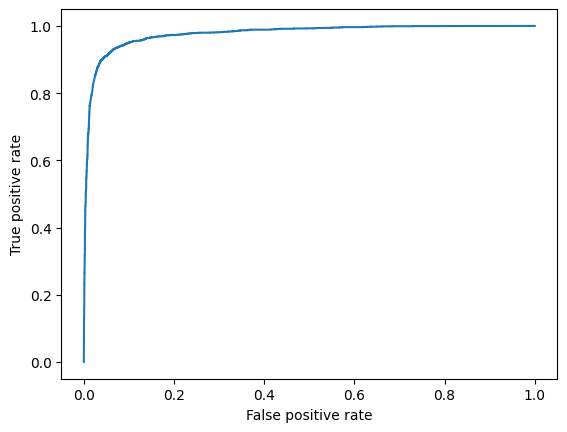

In [38]:
y_pred_array = y_pred.cpu().detach().numpy()

fpr, tpr, _ = roc_curve(Y_test, y_pred_array)

plt.plot(fpr, tpr)
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')

# Other metric results

In [39]:
auroc_score = roc_auc_score(Y_test, y_pred_array)
print(f'AUROC: {auroc_score}')
f1 = f1_score(Y_test, y_pred_array.round())
print(f'F1: {f1}')
precision = precision_score(Y_test, y_pred_array.round())
print(f'Precision: {precision}')
avg_precision = average_precision_score(Y_test, y_pred_array)
print(f'Average precision: {precision}')

AUROC: 0.9766489150832036
F1: 0.865393360618463
Precision: 0.8797965788257051
Average precision: 0.8797965788257051


In [83]:
# Append predicted data to the csv and convert it to shp to visualise in GIS environment
testing = pd.read_csv('data/segments_testing.csv', index_col=0)
testing['landslide_pred'] = y_pred_array.round()
testing_gpd = gpd.GeoDataFrame(testing, geometry=gpd.GeoSeries.from_wkt(testing['geometry']))[['landslide_pred', 'landslide', 'geometry']]
testing_gpd.to_file('data/segments_predicted.shp')

/tmp/ipykernel_39588/3548270539.py:5: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  testing_gpd.to_file('segments_predicted.shp')
